# Binary Classification of Mushroom

Use a __deep neural network__ for classification of mushrooms in _edible_ and _poisonous_.

___Dataset from___: [mushroom-dataset](https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
import numpy as np

2024-06-11 14:14:17.262084: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 14:14:17.428004: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 14:14:18.202444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 14:14:28.950103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#load dataset
df = pd.read_csv('mushroom_cleaned.csv')

## Data Manipulation

Manipualtion of datas to optimize the interpretation from the DNN.

In [3]:
# data normalization and tralation
norm = pd.DataFrame()
for columns in df:
    max_val = np.max(df[columns])
    min_val = np.min(df[columns])
    
    norm[columns] = [min_val , max_val - min_val]
    df[columns]   = (df[columns] - norm[columns][0]) / norm[columns][1]

df

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,0.725542,0.333333,0.333333,0.909091,0.992737,0.432894,0.916667,1.000000,1.0
1,0.772607,0.333333,0.333333,0.909091,0.992737,0.436257,0.916667,1.000000,1.0
2,0.725013,0.333333,0.333333,0.909091,0.941896,0.438778,0.916667,1.000000,1.0
3,0.666843,1.000000,0.333333,0.909091,0.987549,0.438778,0.916667,1.000000,1.0
4,0.690111,1.000000,0.333333,0.909091,0.967835,0.410199,0.916667,0.515404,1.0
...,...,...,...,...,...,...,...,...,...
54030,0.038604,0.833333,0.500000,0.181818,0.231379,0.159428,1.000000,0.515404,1.0
54031,0.043363,0.333333,0.500000,0.181818,0.309197,0.137293,1.000000,0.515404,1.0
54032,0.043363,0.833333,0.500000,0.181818,0.238642,0.163631,1.000000,0.484596,1.0
54033,0.041777,0.333333,0.500000,0.181818,0.269769,0.137574,1.000000,0.484596,1.0


/home/sergio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sergio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sergio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sergio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

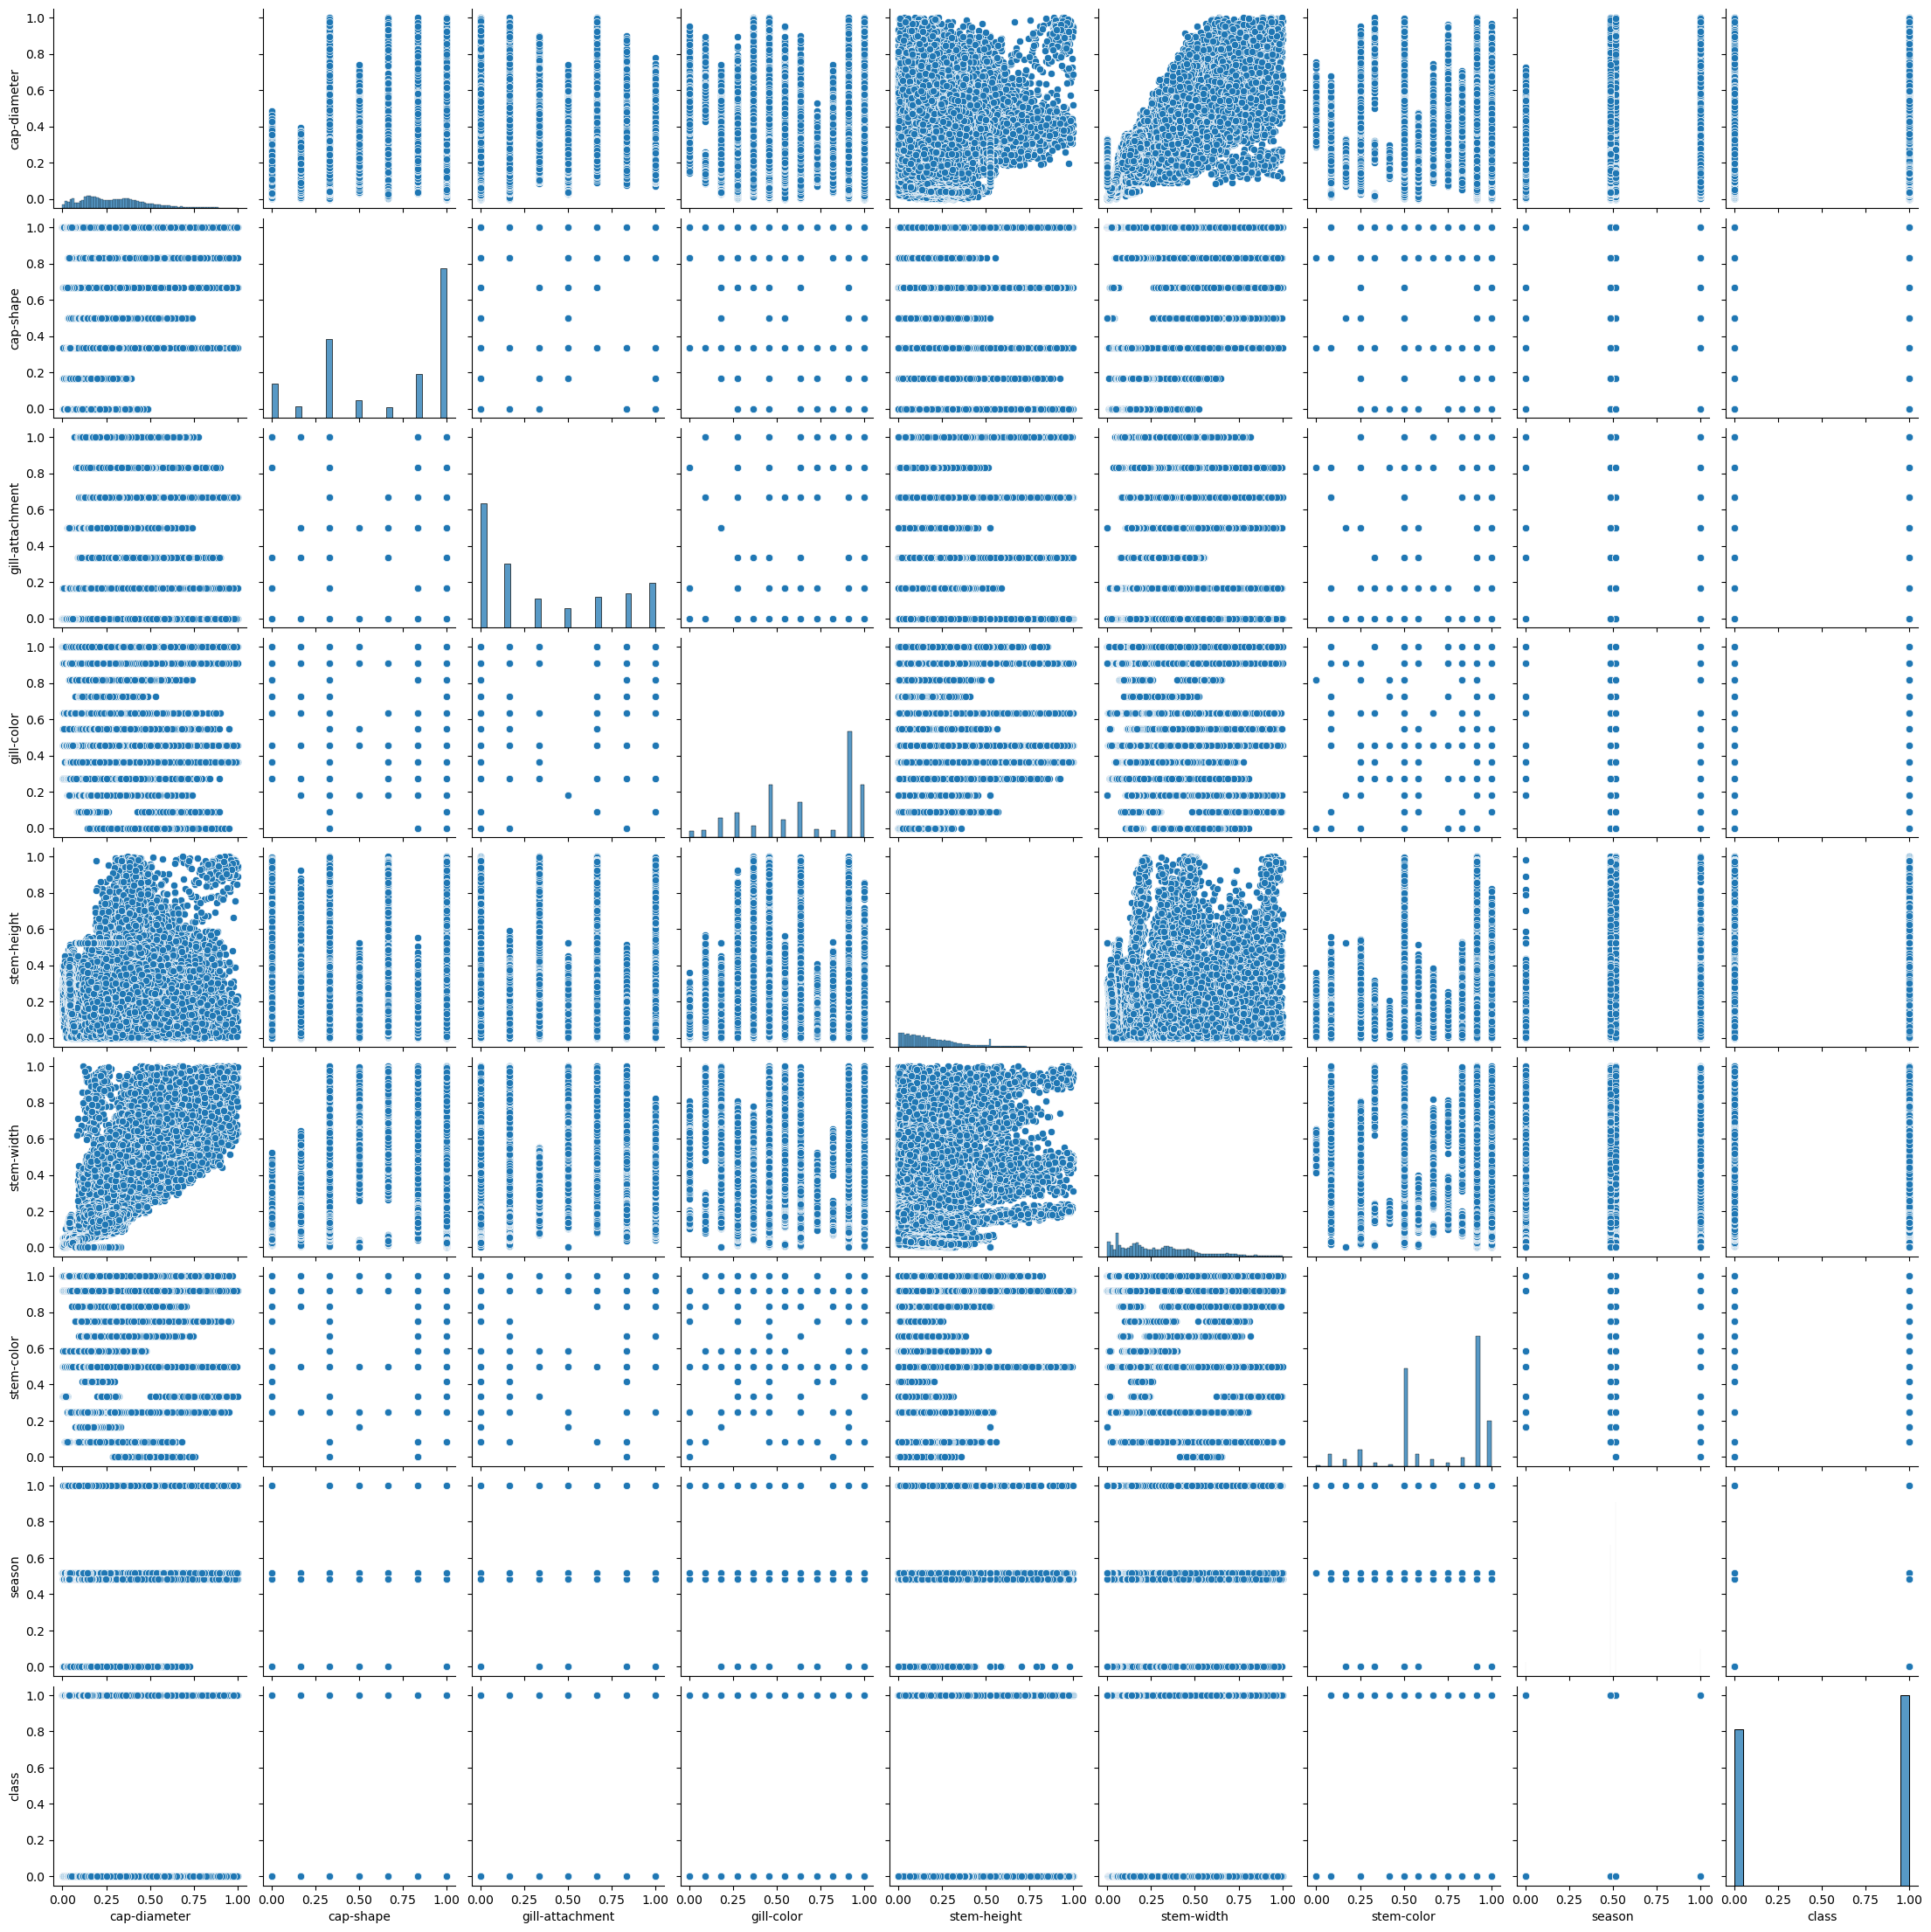

In [4]:
#plot pairplot of the dataset
sns.pairplot(df)
plt.show()

Split the set in test/validation/test datasets.

In [5]:
def divide_set(df , train_ratio , test_ratio , val_ratio = 0):
    print('Ratios:')
    print(f'Train: {train_ratio:.2f} , Vaidation {val_ratio:.2f} , Test: {test_ratio:.2f}')
    assert train_ratio + test_ratio + val_ratio ==1
    appo     = pd.DataFrame(df)
    train_df = appo.sample(frac = train_ratio)
    appo     = appo.drop(train_df.index)
    
    test_ratio /= 1-train_ratio 
    val_ratio  /= 1-train_ratio
    test_df     = appo.sample(frac = test_ratio)
    appo        = appo.drop(test_df.index)
    
    split   = {
        'train' : [train_df.drop(columns = 'class') , train_df['class']] ,
        'val'   : [appo.drop(columns = 'class')    , appo['class']] ,
        'test'  : [test_df.drop(columns = 'class') , test_df['class']]
    }

    return split

df_division = divide_set(df , 0.6 , 0.2  , 0.2)

Ratios:
Train: 0.60 , Vaidation 0.20 , Test: 0.20


## Create the Neural Network 

Create the first model and train to classify the mushrooms.

In [6]:
def create_model(init_nodes):
    model = keras.models.Sequential()
    nodes = init_nodes

    model.add(keras.layers.Dense(nodes , activation = 'relu' , input_shape = (8,) ))
    nodes *= 2
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    nodes = int(nodes * .5)
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    nodes = max(int(nodes / 2) , 1)
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    nodes = max(int(nodes / 2) , 1)
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    model.add(keras.layers.Dense(2   , activation = 'softmax'))

    return model

model = create_model(16)
model.compile(optimizer = 'adam' ,
              loss      = keras.losses.SparseCategoricalCrossentropy() ,
              metrics = ['accuracy'])
model.summary()

/home/sergio/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,454 (9.59 KB)

 Trainable params: 2,454 (9.59 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(df_division['train'][0].to_numpy() , df_division['train'][1].to_numpy() ,
                    validation_data = (df_division['val'][0].to_numpy() , df_division['val'][1].to_numpy()) ,
                    epochs = 100)

Epoch 1/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.6050 - loss: 0.6464 - val_accuracy: 0.6958 - val_loss: 0.5469
Epoch 2/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7199 - loss: 0.5202 - val_accuracy: 0.7710 - val_loss: 0.4518
Epoch 3/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7775 - loss: 0.4401 - val_accuracy: 0.7944 - val_loss: 0.4063
Epoch 4/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.7932 - loss: 0.4053 - val_accuracy: 0.8136 - val_loss: 0.3794
Epoch 5/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.8211 - loss: 0.3738 - val_accuracy: 0.8179 - val_loss: 0.3835
Epoch 6/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8327 - loss: 0.3593 - val_accuracy: 0.8231 - val_loss: 0.3820
Epoch 7/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8520 - loss: 0.3273 - val_accuracy: 0.8589 - val_loss: 0.3123
Epoch 8/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 

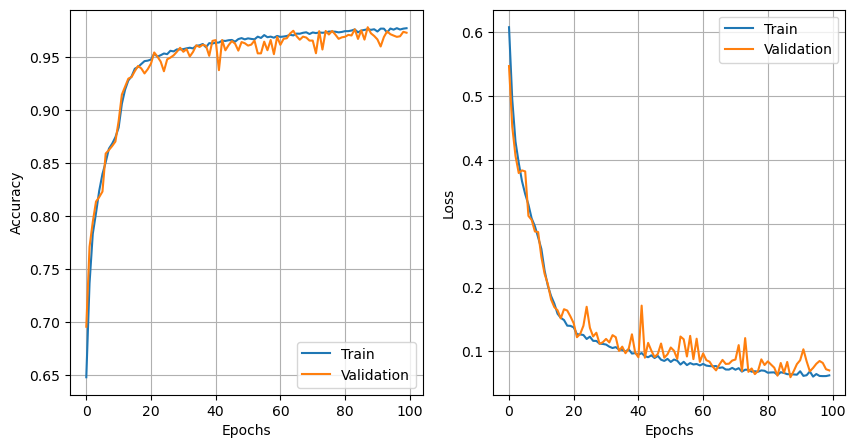

In [9]:
plt.figure(figsize = (10 , 5))

plt.subplot(1 , 2 , 1)

plt.plot(history.history['accuracy']     , label = 'Train')
plt.plot(history.history['val_accuracy'] , label = 'Validation')

plt.legend()
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1 , 2 , 2)

plt.plot(history.history['loss']     , label = 'Train')
plt.plot(history.history['val_loss'] , label = 'Validation')

plt.legend()
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [10]:
vals = model.evaluate(df_division['test'][0].to_numpy() , df_division['test'][1].to_numpy())

print(f"Accuracy {vals[1]*100:.1f} % , Loss {vals[0]:.3f}")

338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9749 - loss: 0.0674
Accuracy 97.4 % , Loss 0.067


The NN converges quikly, I see that the accuracy reach around $90 \%$ in $5$ epochs.

This configuration is prety good, but, I want to study others configurations to find a better one.

## Hyperparamenter Optimization

To optimize the NN I studied the dependencies by:

1. The numbers of nodes in the first layers.
2. The learning rate.

In [11]:
import hyperopt
from hyperopt import hp , tpe , STATUS_OK , Trials , fmin , space_eval

In [12]:
def train(df , params):
    model = create_model(params['init_nodes'])

    optimizer = keras.optimizers.Adam(learning_rate = params['leran_rate'])
    model.compile(optimizer = optimizer ,
                  loss      = keras.losses.SparseCategoricalCrossentropy() ,
                  metrics   = ['accuracy'])

    model.fit(df['train'][0].to_numpy() , df['train'][1].to_numpy() ,
              validation_data = (df['val'][0].to_numpy() , df['val'][1].to_numpy()) ,
              epochs = 5)

    return model

init_params={'init_nodes' : 16 ,
             'leran_rate' : .2}

model = train(df_division , init_params)

/home/sergio/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5252 - loss: 0.6983 - val_accuracy: 0.5546 - val_loss: 0.6876
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5304 - loss: 0.6939 - val_accuracy: 0.4454 - val_loss: 0.7339
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5249 - loss: 0.7002 - val_accuracy: 0.5546 - val_loss: 0.6888
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5331 - loss: 0.6940 - val_accuracy: 0.5546 - val_loss: 0.6877
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5313 - loss: 0.6987 - val_accuracy: 0.5546 - val_loss: 0.7069


In [13]:
def test(model , df):
    evaluation = model.evaluate(df['test'][0].to_numpy() , df['test'][1].to_numpy())

    return evaluation[1]

test(model , df_division)

338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5525 - loss: 0.7082


0.5517719984054565

In [14]:
def hyper_function(params):
    model    = train(df_division , params)
    test_acc = test(model , df_division)

    return {'loss'   : -test_acc ,
            'status' : STATUS_OK}

hyper_function(init_params)

Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.5172 - loss: 0.6958 - val_accuracy: 0.5546 - val_loss: 0.6885
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.5241 - loss: 0.6947 - val_accuracy: 0.5546 - val_loss: 0.6890
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5291 - loss: 0.6946 - val_accuracy: 0.4454 - val_loss: 0.6939
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5309 - loss: 0.6949 - val_accuracy: 0.5546 - val_loss: 0.6911
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5219 - loss: 0.6977 - val_accuracy: 0.5546 - val_loss: 0.6872
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5525 - loss: 0.6877


{'loss': -0.5517719984054565, 'status': 'ok'}

In [15]:
search_space = {'init_nodes' : hp.randint('init_nodes' , 16 , 50) ,
                'leran_rate' : hp.loguniform('leran_rate' , -10 , 0)}

trials = Trials()

In [17]:
best = fmin(hyper_function ,
           space     = search_space ,
           algo      = tpe.suggest ,
           trials    = trials ,
           max_evals = 5 ,
           show_progressbar = False)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/sergio/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/5                                            

   1/1014 ━━━━━━━━━━━━━━━━━━━━ 2:58:47 11s/step - accuracy: 0.5000 - loss: 0.6940
   7/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4895 - loss: 0.6942   
   9/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.4981 - loss: 0.6939
  11/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.5060 - loss: 0.6936
  12/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5077 - loss: 0.6935
  14/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.5108 - loss: 0.6934
  15/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5129 - loss: 0.6933
  18/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.5181 - loss: 0.6930
  19/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5191 - loss: 0.6930
  21/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5212 - loss: 0.6929
  23/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5229 - loss: 0.6928
  25/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5246 - loss

In [18]:
print(space_eval(search_space , best))

{'init_nodes': 31, 'leran_rate': 0.0028182359381908003}


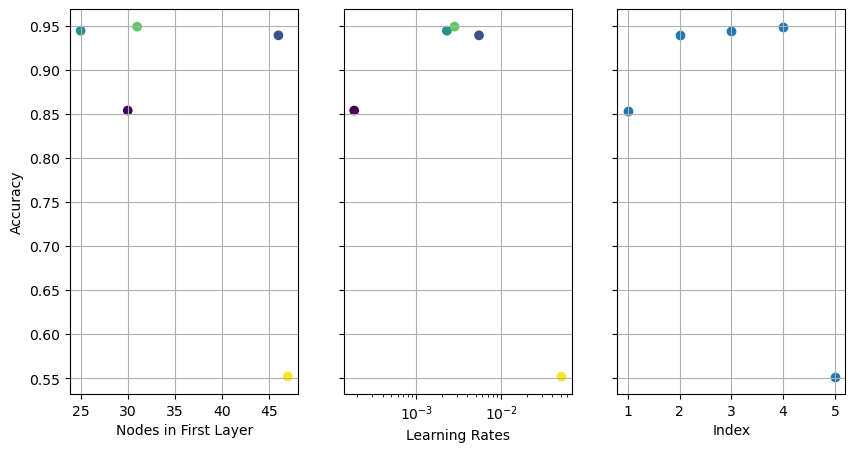

In [54]:
_ , (ax1 , ax2 , ax3) = plt.subplots(1 , 3 , sharey = True , figsize = (10 , 5))

nodes = np.array([t['misc']['vals']['init_nodes'][0] for t in trials.trials])
rates = np.array([t['misc']['vals']['leran_rate'][0] for t in trials.trials])
indxs = np.array([t['tid']+1 for t in trials.trials])
accs  = np.array([-t['result']['loss'] for t in trials.trials])

ax1.scatter(nodes , accs , c = indxs)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Nodes in First Layer')
ax1.grid()

ax2.scatter(rates , accs , c = indxs)
ax2.set(
    xscale = 'log' ,
    xlabel = 'Learning Rates'
)
ax2.grid()

ax3.scatter(indxs , accs)
ax3.set_xlabel('Index')
ax3.grid()

plt.show()

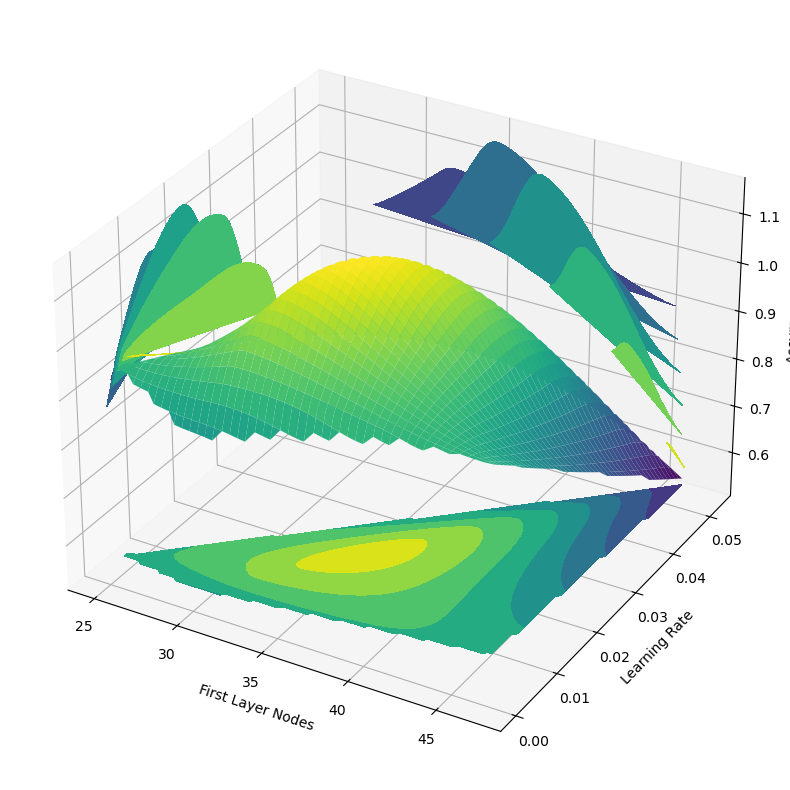

In [117]:
from scipy.interpolate import griddata

xi = np.linspace(min(nodes), max(nodes), 100)
yi = np.linspace(min(rates), max(rates), 100)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((nodes, rates), accs, (xi, yi), method='cubic')

fig = plt.figure(figsize = (10 , 10))
ax = fig.add_subplot(111, projection='3d')



ax.contourf(xi , yi , zi , zdir='z', offset = min(accs), cmap='viridis')
ax.contourf(xi , yi , zi , zdir='x', offset = min(nodes), cmap='viridis')
ax.contourf(xi , yi , zi , zdir='y', offset = max(rates), cmap='viridis')

ax.plot_surface(xi, yi, zi, cmap='viridis')


ax.set(xlabel='First Layer Nodes', ylabel='Learning Rate', zlabel='Accyracy')

plt.show()


/tmp/ipykernel_17028/1934133353.py:5: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  cset = ax.contourf(xi, yi, zi, zdir='x', offset=min(rates), cmap='viridis', alpha=0.5)


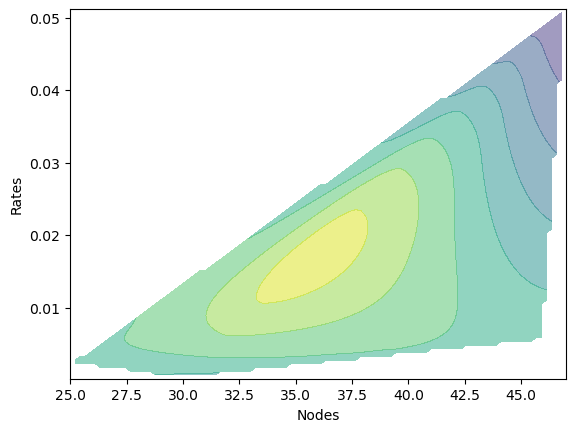

In [118]:
fig = plt.figure()
ax = fig.add_subplot()


cset = ax.contourf(xi, yi, zi, zdir='x', offset=min(rates), cmap='viridis', alpha=0.5)

ax.set_xlabel('Nodes')
ax.set_ylabel('Rates')

plt.show()